In [1]:
pip install -U datasets

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import pandas as pd
import numpy as np
import ast
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback, pipeline
import os
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Disable Weights and Biases to prevent trainer from asking for API key
os.environ["WANDB_DISABLED"] = "true"

In [3]:
from google.colab import drive
import pandas as pd
import ast
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Load your datasets
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'

lfud_logic_train_df = pd.read_csv(f'{data_root_path}/lfud_logic_train.csv').drop(columns = 'label')
lfud_logic_val_df = pd.read_csv(f'{data_root_path}/lfud_logic_val.csv').drop(columns = 'label')

# Encode labels
labels = sorted(lfud_logic_train_df['output'].unique())
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

lfud_logic_train_df['label'] = lfud_logic_train_df['output'].map(label2id)
lfud_logic_val_df['label'] = lfud_logic_val_df['output'].map(label2id)

In [5]:
model_checkpoint = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(example):
    return tokenizer(example["input"], truncation=True, padding="max_length", max_length=512)

train_dataset = Dataset.from_pandas(lfud_logic_train_df[["input", "label"]])
val_dataset = Dataset.from_pandas(lfud_logic_val_df[["input", "label"]])

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
 

Map:   0%|          | 0/3240 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./deberta_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)



Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [17]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1_macro": f1_score(labels, predictions, average="macro"),
        "f1_weighted": f1_score(labels, predictions, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-17-2219676050.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.684800,0.865446,0.752778,0.747396,0.752566
2,0.712000,0.756755,0.780556,0.782378,0.782821
3,0.343600,0.818368,0.805556,0.807185,0.808740
4,0.169900,0.798936,0.830556,0.831201,0.832046


TrainOutput(global_step=1620, training_loss=0.7275745533130787, metrics={'train_runtime': 1790.7938, 'train_samples_per_second': 7.237, 'train_steps_per_second': 0.905, 'total_flos': 3410286593310720.0, 'train_loss': 0.7275745533130787, 'epoch': 4.0})

In [22]:
# Save deberta model
deberta_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/deberta_model'
model.save_pretrained(deberta_model_checkpoint_filepath)

In [ ]:
# Load model to use again
deberta_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/deberta_model'
model, tokenizer = AutoModelForSequenceClassification.from_pretrained(deberta_model_checkpoint_filepath)

In [9]:
# 0. Load LogicClimate dataset for inference
logic_climate_all = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_all.csv').dropna(subset = ['source_article', 'logical_fallacies'])
logic_climate_all['logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('intentional', 'intentional fallacy')

# 1. Drop Equivocation
logic_climate_all = logic_climate_all[logic_climate_all['logical_fallacies'] != 'equivocation']

# 2. Map fallacy of logic label to deductive fallacy
logic_climate_all.loc[:, 'logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('fallacy of logic', 'deductive fallacy')

In [19]:
def predict_label(model, texts, batch_size=32):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    all_preds = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())

    return [id2label[p] for p in all_preds]

logic_climate_preds = predict_label(model, logic_climate_all["source_article"].tolist())
logic_climate_all["deberta_prediction"] = logic_climate_preds

In [13]:
data_root_path

'gdrive/MyDrive/w266/Final Project/data'

Accuracy: 0.2000

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.4167    0.1042    0.1667        96
            ad populum     0.1667    0.1111    0.1333        63
     appeal to emotion     0.3293    0.1915    0.2422       141
    circular reasoning     0.0476    0.1429    0.0714         7
     deductive fallacy     0.1127    0.0909    0.1006        88
fallacy of credibility     0.3495    0.2748    0.3077       131
  fallacy of extension     0.1935    0.1875    0.1905        64
  fallacy of relevance     0.1049    0.1650    0.1283       103
       false causality     0.1640    0.5616    0.2539        73
         false dilemma     0.1538    0.0408    0.0645        49
 faulty generalization     0.1392    0.3233    0.1946       133
   intentional fallacy     0.3630    0.1573    0.2195       337

              accuracy                         0.2000      1285
             macro avg     0.2117    0.1959    0.1728      12

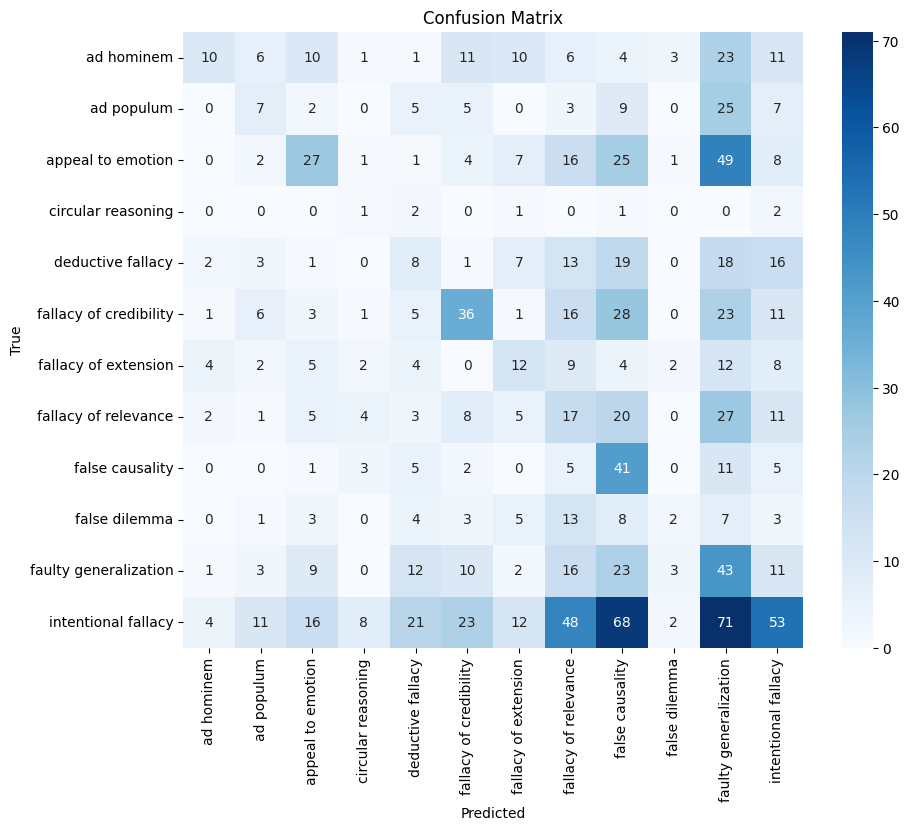

In [21]:
# Make sure the labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['deberta_prediction'].astype(str)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Now let's try bert base uncased

In [26]:
del model, tokenizer

In [27]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(example):
    return tokenizer(example["input"], truncation=True, padding="max_length", max_length=512)

train_dataset = Dataset.from_pandas(lfud_logic_train_df[["input", "label"]])
val_dataset = Dataset.from_pandas(lfud_logic_val_df[["input", "label"]])

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)

tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "label"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3240 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [28]:
bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [29]:
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-29-3542017785.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,1.685700,0.941799,0.713889,0.704148,0.708871
2,0.681900,0.770887,0.786111,0.786934,0.789547
3,0.234100,0.877685,0.780556,0.781999,0.781789
4,0.079100,0.855911,0.797222,0.797267,0.797819


TrainOutput(global_step=1620, training_loss=0.6702072755790051, metrics={'train_runtime': 1313.1132, 'train_samples_per_second': 9.87, 'train_steps_per_second': 1.234, 'total_flos': 3410225440358400.0, 'train_loss': 0.6702072755790051, 'epoch': 4.0})

In [32]:
# Save bert-base-cased model
bert_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/bert-base-cased-model'
bert_model.save_pretrained(bert_model_checkpoint_filepath)

In [ ]:
# Load model to use again
bert_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/bert-base-cased-model'
model, tokenizer = AutoModelForSequenceClassification.from_pretrained(bert_model_checkpoint_filepath)

In [35]:
logic_climate_preds = predict_label(bert_model, logic_climate_all["source_article"].tolist())
logic_climate_all["bert_base_cased_prediction"] = logic_climate_preds

logic_climate_all.to_csv(f'{data_root_path}/logic_climate_predictions_bert_base_cased.csv')

Accuracy: 0.2101

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.5000    0.1771    0.2615        96
            ad populum     0.1111    0.0794    0.0926        63
     appeal to emotion     0.3721    0.2270    0.2819       141
    circular reasoning     0.0000    0.0000    0.0000         7
     deductive fallacy     0.1148    0.0795    0.0940        88
fallacy of credibility     0.3246    0.2824    0.3020       131
  fallacy of extension     0.2619    0.1719    0.2075        64
  fallacy of relevance     0.0723    0.1165    0.0892       103
       false causality     0.1219    0.5342    0.1985        73
         false dilemma     0.1765    0.0612    0.0909        49
 faulty generalization     0.1626    0.2481    0.1964       133
   intentional fallacy     0.4253    0.2196    0.2896       337

              accuracy                         0.2101      1285
             macro avg     0.2202    0.1831    0.1754      12

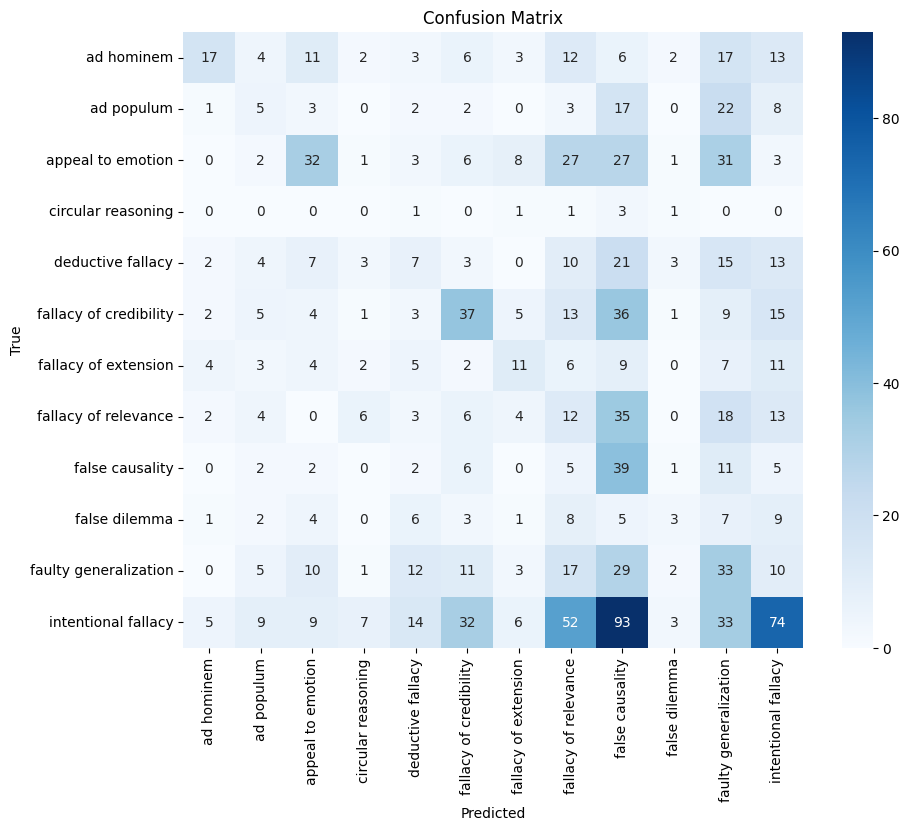

In [37]:
# Make sure the labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['bert_base_cased_prediction'].astype(str)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()